<a href="https://colab.research.google.com/github/teoalcdor/trabajo_iae/blob/main/od_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de Detección de Objetos

Para la tarea de detección de objetos vamos a utilizar los modelos SSD3000 y YOLOv5. Los descargaremos ya pre-entrenado, y les haremos *transfer learning*.

## Librerías

In [ ]:
!pip install torchinfo
!pip install torchmetrics
!pip install ultralytics

# Solo si se va a entrenar YOLOv5, instalar otra vez despues
!pip uninstall -y albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
%matplotlib inline
import cv2
from google.colab import drive
import numpy as np
from math import inf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision import transforms
from torchvision.models.detection.ssd import SSDHead
from torchvision.ops import nms
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Dispositivo

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

In [ ]:
def train_batch(inputs, model, optimizer):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos los pares imagen-anotacion como marca la documentacion
    input, targets = inputs
    input = [image for image in input]
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    # Obtenemos la perdida
    losses = model(input, targets) # En modo entrenamiento devuelve un diccionario con las perdidas
    loss = losses["classification"] + 1 * losses["bbox_regression"]

     # Calculamos el gradiente de la perdida con retropropagacion
    loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return loss, losses

@torch.no_grad()
def validate_batch(inputs, model):
    """
    Calcula la accuracy del modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos los pares imagen-anotacion como marca la documentacion
    input, targets = inputs
    input = [image.to(DEVICE) for image in input]
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    # Obtenemos la perdida
    losses = model(input, targets) # En modo entrenamiento devuelve un diccionario con las perdidas
    loss = losses["classification"] + 1 * losses["bbox_regression"]
    return loss, losses

def train_model(model, optimizer, train_dataloader, val_dataloader, epochs=10):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la pérdida total en validación. Devuelve también las pérdidas encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas
    train_losses = []
    train_losses_classifier = []
    train_losses_box_reg = []
    val_losses = []
    val_losses_classifier = []
    val_losses_box_reg = []

    # Inicializamos el mecanismo de early stopping
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "min_val_loss": inf
    }


    for epoch in range(epochs):
        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 79)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_losses = []
        train_epoch_losses_classifier = []
        train_epoch_losses_box_reg = []
        val_epoch_losses = []
        val_epoch_losses_classifier = []
        val_epoch_losses_box_reg = []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for inputs in tqdm(train_dataloader, total=_n, desc="- Training"):
            loss, losses = train_batch(inputs, model, optimizer)
            loc_loss, regr_loss = \
                [losses[k] for k in ["bbox_regression", "classification"]]
            train_epoch_losses.append(loss.item())
            train_epoch_losses_classifier.append(loc_loss.item())
            train_epoch_losses_box_reg.append(regr_loss.item())

        # Calculamos las perdidas sobre el conjunto de validacion
        _n = len(val_dataloader)
        for inputs in tqdm(val_dataloader, total=_n, desc="- Validation"):
            loss, losses = validate_batch(inputs, model)
            loc_loss, regr_loss = \
                [losses[k] for k in ["bbox_regression", "classification"]]
            val_epoch_losses.append(loss.item())
            val_epoch_losses_classifier.append(loc_loss.item())
            val_epoch_losses_box_reg.append(regr_loss.item())

        # Actualizamos las perdidas y accuracies
        train_losses.append(np.mean(train_epoch_losses))
        train_losses_classifier.append(np.mean(train_epoch_losses_classifier))
        train_losses_box_reg.append(np.mean(train_epoch_losses_box_reg))
        val_losses.append(np.mean(val_epoch_losses))
        val_losses_classifier.append(np.mean(val_epoch_losses_classifier))
        val_losses_box_reg.append(np.mean(val_epoch_losses_box_reg))

        # Ponemos en marcha el mecanismo de early stopping
        if val_losses[-1] < best_model["min_val_loss"]:
            best_model["min_val_loss"] = val_losses[-1]
            best_model["model_state_dict"] = model.state_dict()
            best_model["optimizer_state_dict"] = optimizer.state_dict()
            best_model["epoch"] = epoch + 1

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print("=" * 79)
        print()

    return train_losses, train_losses_classifier, train_losses_box_reg, \
              val_losses, val_losses_classifier, val_losses_box_reg, best_model



def plot_training_results(train_losses, val_losses,
                          xlabel="Epochs", ylabel="Loss", title="Training Results"):
    """
    Representa la pérdida del modelo en el entrenamiento sobre los conjuntos de entrenamiento
    y validación.
    """

    # Diccionario con las perdidas
    losses = pd.DataFrame(
        {"Entrenamiento": train_losses,
         "Validación": val_losses})

    # Representacion grafica
    with sns.axes_style("whitegrid"):
        losses_plot = sns.lineplot(data=losses)
        losses_plot.set(
            xlabel=xlabel,
            ylabel=ylabel,
            title=title
        )
        plt.show()

def decode_output_ssd(output, conf_threshold=0.5):
    """
    Decodifica la salida de SSD300 para que sea posible representarla y
    calcular la mAP.
    """

    # Extraemos las partes de la salida
    bbs = output["boxes"].cpu().detach()
    labels = torch.tensor([i - 1 for i in output["labels"].cpu()])
    confs = output["scores"].cpu().detach()

    # Filtramos en las detecciones
    all_ixs = torch.arange(0, len(confs))
    ixs = torch.tensor([], dtype=torch.int32) # Los indices de las detecciones con las que nos quedamos

    for label in labels.unique():
        label_mask = labels == label # Seleccionamos las detecciones de una clase

        label_ixs = nms(bbs[label_mask], confs[label_mask], 0.05) # Hacemos Non-max suppression

        real_ixs = all_ixs[label_mask][label_ixs] # Seleccionamos solo las detecciones que pasan la nms

        final_ixs = real_ixs[confs[real_ixs] > 0.5] # Seleccionamos solo los indices con confianza > 0.5

        ixs = torch.cat((ixs, final_ixs)) # Nos quesamos con los indices de las detecciones de esta clase que pasan el filtro

    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]] # Filtramos las cajas, confianzas y etiquetas

    return bbs, confs, labels

def adapt_bbs(bbs, image):
    """
    Adapta las cajas de las detecciones de una imagen de formato 300x300 a las dimensiones
    de la imagen
    """
    real_w, real_h = image.shape[1], image.shape[0]
    bbs[:, 0:3:2] = bbs[:, 0:3:2] * real_w / 300
    bbs[:, 1:4:2] = bbs[:, 1:4:2] * real_h / 300

    return bbs

@torch.no_grad()
def measure_fps_ssd(model, dataset, dataloader):
    """
    Estima los FPS a los que detecta SSD300. Se tiene el cuenta el post-procesamiento.
    """

    model.eval() # Modo evaluacion
    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de todas
    # las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for ix_dataloader, batch in enumerate(dataloader):
        for ix_batch, img in enumerate(batch[0]):
            image = dataset[ix_dataloader * 4 + ix_batch][0]
            output = model(img.unsqueeze(0))[0]
            output = decode_output_ssd(output)
            _ = adapt_bbs(output[0], image)

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps

@torch.no_grad()
def calcula_map_ssd(model, dataset, dataloader, iou_list=[0.5]):
    """
    Calcula el mAP a distintos umbrales y su media para SSD300.
    """

    map_dict = {}
    model.eval()
    preds = []
    targets = []

    n = len(dataloader)

    # Hacemos las detecciones sobre las imagenes y las ponemos en una lista con el
    # formato de la documentacion de MeanAveragePrecision.
    for ix_dataloader, batch in tqdm(enumerate(dataloader), total = n):

      for ix_batch, img in enumerate(batch[0]):
        image = dataset[ix_dataloader * 4 + ix_batch][0]

        output = model(img.unsqueeze(0))[0]
        output = decode_output_ssd(output)

        bbs = adapt_bbs(output[0], image)
        preds.append({"boxes": bbs, "scores": output[1], "labels": output[2]})

        true_bbs = torch.tensor(dataset[ix_dataloader * 4 + ix_batch][1], dtype=torch.float32)
        true_labels = torch.tensor(dataset[ix_dataloader * 4 + ix_batch][2])
        targets.append({"boxes": true_bbs, "labels": true_labels})

    # Calculamos la mAP a distintos umbrales
    for iou in iou_list:
        metric = MeanAveragePrecision(iou_thresholds=[iou])
        metric.update(preds, targets)
        results = metric.compute()
        map_dict[f"map@{iou}"] = results
        print(f"mAP@{iou}: {results['map']:.4f}")

    # Calculamos la media si se da mas de un umbral
    if len(iou_list) > 1:
        metric = MeanAveragePrecision(iou_thresholds=list(iou_list))
        metric.update(preds, targets)
        results = metric.compute()
        map_dict["map"] = results["map"]
        print(f"Average mAP: {results['map']:.4f}")

    return map_dict

def decode_output_yolo(output, conf_threshold=0.5):
    """
    Decodifica la salida de YOLOv5 para que sea posible representarla y
    calcular la mAP.
    """

    # Extraemos las partes de la salida
    bbs = output[0].boxes.xyxy.cpu()
    confs = output[0].boxes.conf.cpu()
    labels = output[0].boxes.cls.cpu().int()

    # Nos quedamos con las detecciones que superen cierto umbral
    ixs = (confs > conf_threshold)

    # Filtramos las detecctiones
    bbs = bbs[ixs]
    confs = confs[ixs]
    labels = labels[ixs]

    return bbs, confs, labels


@torch.no_grad()
def measure_fps_yolo(model, dataset):
    """
    Estima los FPS a los que detecta SSD300. Se tiene el cuenta el post-procesamiento.
    """

    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de todas
    # las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for data in dataset:
        output = model.predict(data[0], device=0, verbose = False)
        _ = decode_output_yolo(output)

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps


@torch.no_grad()
def measure_map_yolo(model, dataset, iou_list=[0.5]):
    """
    Calcula el mAP a distintos umbrales y su media para SSD300.
    """

    map_dict = {}
    preds = []
    targets = []

    n = len(dataset)

    # Hacemos las detecciones sobre las imagenes y las ponemos en una lista con el
    # formato de la documentacion de MeanAveragePrecision.
    for data in tqdm(dataset, total = n):
        image = data[0]

        output = model.predict(image, device=0, verbose = False)
        bbs, confs, labels = decode_output_yolo(output)

        preds.append({"boxes": bbs, "scores": confs, "labels": labels})

        true_bbs = torch.tensor(data[1], dtype=torch.float32)
        true_labels = torch.tensor(data[2])
        targets.append({"boxes": true_bbs, "labels": true_labels})

    # Calculamos la mAP a distintos umbrales
    for iou in iou_list:
        metric = MeanAveragePrecision(iou_thresholds=[iou])
        metric.update(preds, targets)
        results = metric.compute()
        map_dict[f"map@{iou}"] = results
        print(f"mAP@{iou}: {results['map']:.4f}")

    # Calculamos la media si se da mas de un umbral
    if len(iou_list) > 1:
        metric = MeanAveragePrecision(iou_thresholds=list(iou_list))
        metric.update(preds, targets)
        results = metric.compute()
        map_dict["map"] = results["map"]
        print(f"Average mAP: {results['map']:.4f}")

    return map_dict

def plot_training_results_yolo(results_path):
    """
    Representa la evolución de las pérdidas de YOLOv5 a lo largo del entrenamiento
    """

    results = pd.read_csv(results_path)

    results["train_loss"] = results["train/box_loss"] + results["train/dfl_loss"] + results["train/cls_loss"]
    results["val_loss"] = results["val/box_loss"] + results["val/dfl_loss"] + results["val/cls_loss"]

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 4, figsize=(12, 3))
        losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train_loss"],
                "Validación": results["val_loss"],
            },
            ax = axs[0],
        )
        losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida Total",
        )
        axs[0].set_xticks([0, 4, 9, 14, 19])
        axs[0].set_xticklabels([1, 5, 10, 15, 20])

        cls_losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train/cls_loss"],
                "Validación": results["val/cls_loss"],
            },
            ax = axs[1],
        )
        cls_losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida Clasificación",
        )
        axs[1].set_xticks([0, 4, 9, 14, 19])
        axs[1].set_xticklabels([1, 5, 10, 15, 20])

        box_losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train/box_loss"],
                "Validación": results["val/box_loss"],
            },
            ax = axs[2],
        )
        box_losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida de Regresión de las Cajas",
        )
        axs[2].set_xticks([0, 4, 9, 14, 19])
        axs[2].set_xticklabels([1, 5, 10, 15, 20])

        dfl_losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train/dfl_loss"],
                "Validación": results["val/dfl_loss"],
            },
            ax = axs[3],
        )
        dfl_losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida de Distribución Focal",
        )
        axs[3].set_xticks([0, 4, 9, 14, 19])
        axs[3].set_xticklabels([1, 5, 10, 15, 20])
        plt.tight_layout()
        plt.show()


def plot_training_results_ssd(results):
    """
    Representa la evolución de las pérdidas de SSD300 a lo largo del entrenamiento.
    """

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train_losses"],
                "Validación": results["val_losses"],
            },
            ax = axs[0],
        )
        losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida Total",
        )
        axs[0].set_xticks([0, 4, 9, 14, 19])
        axs[0].set_xticklabels([1, 5, 10, 15, 20])

        cls_losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train_losses_classifier"],
                "Validación": results["val_losses_classifier"],
            },
            ax = axs[1],
        )
        cls_losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida Clasificación",
        )
        axs[1].set_xticks([0, 4, 9, 14, 19])
        axs[1].set_xticklabels([1, 5, 10, 15, 20])

        box_losses_plot = sns.lineplot(
            data = {
                "Entrenamiento": results["train_losses_box_reg"],
                "Validación": results["val_losses_box_reg"],
            },
            ax = axs[2],
        )
        box_losses_plot.set(
            xlabel="Epochs",
            ylabel="Pérdida de Regresión de las Cajas",
        )
        axs[2].set_xticks([0, 4, 9, 14, 19])
        axs[2].set_xticklabels([1, 5, 10, 15, 20])

        plt.tight_layout()
        plt.show()

## Datos

Montamos nuestra cuenta de Google Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Descomprimimos el archivo:

In [ ]:
zip_path = "/content/drive/MyDrive/trabajo_iae/datasets/od_dataset_clean.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Importamos los dataframes con las anotaciones en PascalVOC:

In [ ]:
train_annotations = pd.read_feather("/content/drive/MyDrive/trabajo_iae/datasets/od_dataset_df/od_dataset_pv_train.feather")
val_annotations = pd.read_feather("/content/drive/MyDrive/trabajo_iae/datasets/od_dataset_df/od_dataset_pv_val.feather")
test_annotations = pd.read_feather("/content/drive/MyDrive/trabajo_iae/datasets/od_dataset_df/od_dataset_pv_test.feather")

# Descomentar si no lo corremos en colab
# train_annotations = pd.read_feather("datasets/od_dataset_df/od_dataset_pv_train.feather")
# val_annotations = pd.read_feather("datasets/od_dataset_df/od_dataset_pv_val.feather")
# test_annotations = pd.read_feather("datasets/od_dataset_df/od_dataset_pv_test.feather")

Creamos las clases de los *datsets* de esta tarea para SSD300 y YOLOv5:

In [ ]:
class ObjectDetectionDatasetSSD300(Dataset):
    def __init__(self, annotations, images_path, w=300, h=300):
        self.w = w
        self.h = h
        self.images_path = images_path
        self.annotations = annotations
        self.images = self.annotations["image"].unique()
        self.basic_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.w, self.h)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        image_id = self.images[ix]
        image_path = f"{self.images_path}/{image_id}"
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = self.annotations[self.annotations["image"] == image_id]

        labels = data["class"].values

        data = data[["xmin", "ymin", "xmax", "ymax"]].values
        boxes = data.astype(np.uint32)

        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = tuple(zip(*batch))
        images_list = []
        targets_list = []
        for ix, image in enumerate(images):
            target = {}
            real_w, real_h = image.shape[1], image.shape[0]
            image = self.basic_transform(image)

            images_list.append(image)

            boxes_array = boxes[ix]
            boxes_array[:, 0] = boxes_array[:, 0] * self.w / real_w
            boxes_array[:, 1] = boxes_array[:, 1] * self.h / real_h
            boxes_array[:, 2] = boxes_array[:, 2] * self.w / real_w
            boxes_array[:, 3] = boxes_array[:, 3] * self.h / real_h

            target["boxes"] = torch.Tensor(boxes_array).float().to(DEVICE)
            target["labels"] = torch.Tensor([label + 1 for label in labels[ix]]).long().to(DEVICE)

            targets_list.append(target)


        images = torch.stack(images_list).to(DEVICE)

        return images, targets_list

In [ ]:
class ObjectDetectionDatasetYOLOv5(Dataset):

    def __init__(self, annotations, images_path, corrupt=set()):
        self.images_path = images_path
        self.annotations = annotations[~annotations["image"].isin(corrupt)]
        self.filenames = self.annotations["image"].unique()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, ix):
        image_id = self.filenames[ix]
        image_path = f"{self.images_path}/{image_id}"
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = self.annotations[self.annotations["image"] == image_id]

        labels = data["class"].values

        data = data[["xmin", "ymin", "xmax", "ymax"]].values
        boxes = data.astype(np.uint32)

        return img, boxes, labels

Instanciamos las clases de los *datasets* y los *dataloaders*:

In [ ]:
## SSD300
# Conjunto de entrenamiento
train_dataset_ssd300 = ObjectDetectionDatasetSSD300(
    images_path="/content/od_dataset_clean/images/train/", # "datasets/od_dataset_clean/images/train/"
    annotations=train_annotations,
)
train_dataloader_ssd300 = DataLoader(train_dataset_ssd300, batch_size=16,
                                     collate_fn=train_dataset_ssd300.collate_fn,
                                     shuffle=True)

# Conjunto de validacion
val_dataset_ssd300 = ObjectDetectionDatasetSSD300(
    images_path="/content/od_dataset_clean/images/val/", # "datasets/od_dataset_clean/images/val/"
    annotations=val_annotations,
)
val_dataloader_ssd300 = DataLoader(val_dataset_ssd300, batch_size=4,
                                   collate_fn=val_dataset_ssd300.collate_fn)

# Conjunto de test
test_dataset_ssd300 = ObjectDetectionDatasetSSD300(
    images_path="/content/od_dataset_clean/images/test/", # "datasets/od_dataset_clean/images/test/"
    annotations=test_annotations,
)
test_dataloader_ssd300 = DataLoader(test_dataset_ssd300, batch_size=4,
                                    collate_fn=test_dataset_ssd300.collate_fn)


## YOLOv5
# Conjunto de validacion
val_dataset_yolov5 = ObjectDetectionDatasetYOLOv5(
    images_path="/content/od_dataset_clean/images/val/",
    annotations=val_annotations,
)

# Conjunto de test
test_dataset_yolov5 = ObjectDetectionDatasetYOLOv5(
    images_path="/content/od_dataset_clean/images/test/",
    annotations=test_annotations,
)

## SSD300

### Modelo

Echamos un vistazo al modelo:

In [ ]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
summary(model,  input_data=torch.rand(1, 3, 300, 300))

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 84.1MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [101, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 150, 150]     

In [ ]:
model.head.classification_head

SSDClassificationHead(
  (module_list): ModuleList(
    (0): Conv2d(512, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(1024, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4-5): 2 x Conv2d(256, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Definimos una función que congele todas los pesos de las capas del modelo y sustituya la cabeza por una adaptada a nuestras clases con los pesos descongelados:

In [ ]:
def get_model_ssd300(num_classes):
    """
    Nos permite obtener un modelo SSD300 listo para aplicar transfer learning
    (con su cabeza descongelada) y su optimizador (Adam).
    """

    model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

    for param in model.backbone.parameters():
        param.requires_grad = False

    in_channels = \
    [layer.in_channels for layer in model.head.classification_head.module_list]

    boxes_per_class_1 = 364 // 91
    boxes_per_class_2 = 546 // 91

    num_anchors = [boxes_per_class_1] + \
      3 * [boxes_per_class_2] + \
      2 * [boxes_per_class_1]

    model.head = SSDHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes + 1
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    return model.to(DEVICE), optimizer

Obtenemos el modelo listo para entrenar:

In [ ]:
model_ssd300, optimizer = get_model_ssd300(num_classes=11)
summary(model_ssd300, input_size=(1, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [200, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 150, 150] 

Entrenamos el modelo:

In [ ]:
train_losses, train_losses_classifier, train_losses_box_reg, \
    val_losses, val_losses_classifier, val_losses_box_reg, \
    best_model = \
    train_model(model_ssd300, optimizer, train_dataloader_ssd300, val_dataloader_ssd300, epochs=1)

Epoch: 1 - Started: 25/05/25 22:21:26


- Validation: 100%|██████████| 407/407 [00:51<00:00,  7.97it/s]

Epoch: 1 - Ended: 25/05/25 22:28:15 - Duration: 408.94s

Training Loss: 6.21949133940146 - Validation Loss: 3.8594410738722407



Guardamos los frutos del entrenamiento (serializamos en pth, propio de Pytorch):

In [ ]:
torch.save({
    "epoch": 20,
    "model_state_dict": model_ssd300.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": train_losses[-1],
    "train_losses": train_losses,
    "train_losses_classifier": train_losses_classifier,
    "train_losses_box_reg": train_losses_box_reg,
    "val_losses": val_losses,
    "val_losses_classifier": val_losses_classifier,
    "val_losses_box_reg": val_losses_box_reg,
    "best_model": best_model
    }, "/content/drive/MyDrive/trabajo_iae/modelos/ssd300.pth" # "modelos/ssd300.pth"
)

### Resultados

Cargamos el checkpoint:

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/trabajo_iae/modelos/ssd300.pth", weights_only=False) # "modelos/ssd300.pth"

model_ssd300, _ = get_model_ssd300(11)
model_ssd300.load_state_dict(checkpoint["best_model"]["model_state_dict"])

Representamos la evolución de las distintas pérdidas del modelo durante el entrenamiento:

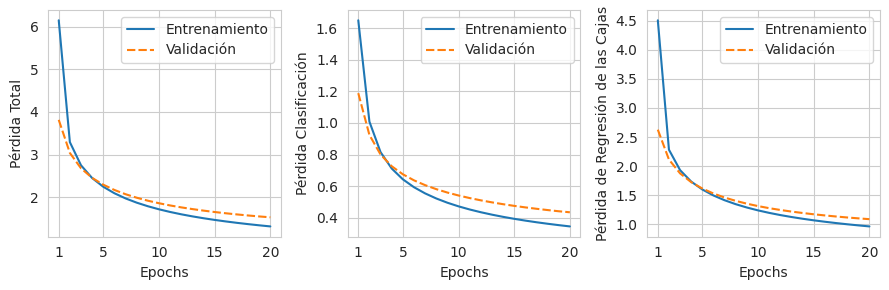

In [ ]:
plot_training_results_ssd(checkpoint)

Estimamos los FPS del modelo:

In [ ]:
_ = measure_fps_ssd(model_ssd300, val_dataset_ssd300, val_dataloader_ssd300)

FPS: 20.99


Medimos la mAP del modelo:

In [ ]:
_ = calcula_map_ssd(model_ssd300, val_dataset_ssd300, val_dataloader_ssd300, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 407/407 [01:46<00:00,  3.81it/s]


mAP@0.5: 0.6769
mAP@0.55: 0.6676
mAP@0.6: 0.6529
mAP@0.65: 0.6343
mAP@0.7: 0.6031
mAP@0.75: 0.5537
mAP@0.8: 0.4624
mAP@0.85: 0.3097
mAP@0.9: 0.1008
mAP@0.95: 0.0054
Average mAP: 0.4667


## YOLOv5

### Modelo

Creamos el archivo YAML necesario para configurar el modelo:

In [ ]:
%%writefile od_dataset.yaml

path: od_dataset_clean
train: images/train
val: images/val

# Classes
names:
  0: Tank (TANK)
  1: Infantry fighting vehicle (IFV)
  2: Armored personnel carrier (APC)
  3: Engineering vehicle (EV)
  4: Assault helicopter (AH)
  5: Transport helicopter (TH)
  6: Assault airplane (AAP)
  7: Transport airplane (TA)
  8: Anti-aircraft vehicle (AA)
  9: Towed artillery (TART)
  10: Self-propelled artillery (SPART)

augment: False

Writing od_dataset.yaml


Obtenemos el modelo:

In [ ]:
model_yolov5 = YOLO("yolov5m.pt")

PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 48.2M/48.2M [00:00<00:00, 76.3MB/s]


Entrenamos el modelo, tratando de que las condiciones sean lo más parecidas posibles a SSD300:

In [ ]:
_ = model_yolov5.train(
    data="od_dataset.yaml", # datasets/od_dataset.yaml
    epochs=1,
    device="cuda",
    augment=False,
    optimizer='AdamW',
    lr0=1e-4,
    lrf=1.0,
    weight_decay=1e-5,
    momentum=0.9,
    name="yolov5" # + project=modelos
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=od_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=1.0, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5m.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=yolov5, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]

Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytic

 20                  -1  2   1035264  ultralytics.nn.modules.block.C3              [384, 384, 2, False]          
 21                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 22            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 23                  -1  2   4134912  ultralytics.nn.modules.block.C3              [768, 768, 2, False]          
 24        [17, 20, 23]  1   4224433  ultralytics.nn.modules.head.Detect           [11, [192, 384, 768]]         
YOLOv5m summary: 197 layers, 25,071,505 parameters, 25,071,489 gradients, 64.4 GFLOPs

Transferred 553/559 items from pretrained weights
Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 84.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 873.3±1349.8 MB/s, size: 101.9 KB)


train: Scanning /content/od_dataset_clean/labels/train... 11350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11350/11350 [00:10<00:00, 1054.46it/s]


train: New cache created: /content/od_dataset_clean/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.3±180.3 MB/s, size: 173.1 KB)


val: Scanning /content/od_dataset_clean/labels/val... 1627 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1627/1627 [00:01<00:00, 929.71it/s] 

val: New cache created: /content/od_dataset_clean/labels/val.cache


Plotting labels to runs/detect/yolov5/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=1e-05), 97 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov5
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1       6.1G      1.659       1.48      1.469         27        640: 100%|██████████| 710/710 [06:05<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:21<00:00,  2.35it/s]


                   all       1627       3941      0.856      0.777      0.846      0.484

1 epochs completed in 0.119 hours.
Optimizer stripped from runs/detect/yolov5/weights/last.pt, 50.5MB
Optimizer stripped from runs/detect/yolov5/weights/best.pt, 50.5MB

Validating runs/detect/yolov5/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5m summary (fused): 106 layers, 25,051,585 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


                   all       1627       3941      0.854      0.775      0.845      0.484
           Tank (TANK)        288        663      0.794      0.811      0.837      0.444
Infantry fighting vehicle (IFV)        117        229      0.957      0.675      0.845      0.483
Armored personnel carrier (APC)        183        775      0.848      0.817       0.85      0.497
Engineering vehicle (EV)        245        280      0.839      0.993       0.98      0.665
Assault helicopter (AH)         84        242      0.899      0.405      0.649      0.282
Transport helicopter (TH)         83        116      0.922      0.733      0.805        0.4
Assault airplane (AAP)         80        115      0.977      0.744      0.841      0.391
Transport airplane (TA)        158        359      0.843      0.913      0.954      0.633
Anti-aircraft vehicle (AA)         56        153      0.823      0.935      0.944      0.682
Towed artillery (TART)        214        289      0.893      0.778      0.871    

In [ ]:
import shutil

In [ ]:
shutil.make_archive(
    "yolov5",
    "zip",
    "/content/runs/detect/",
    "yolov5"
)

'/content/yolov5.zip'

In [ ]:
shutil.copy(
    "/content/yolov5.zip",
    "/content/drive/MyDrive/trabajo_iae/modelos/yolov5.zip"
)

'/content/drive/MyDrive/trabajo_iae/modelos/yolov5.zip'

In [ ]:
shutil.rmtree("/content/runs")

### Resultados

Extraemos el checkpoint:

In [ ]:
# No correr si ya se tiene la carpeta yolov5
zip_path = "/content/drive/MyDrive/trabajo_iae/modelos/yolov5.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Obtenemos el mejor modelo de nuestro Checkpoint:

In [ ]:
model_yolov5 = YOLO("yolov5/weights/best.pt") # "modelos/yolov5/weights/best.pt"

Representamos la evolución de las pérdidas en los conjuntos de entrenamiento y validación a lo largo del entrenamiento:

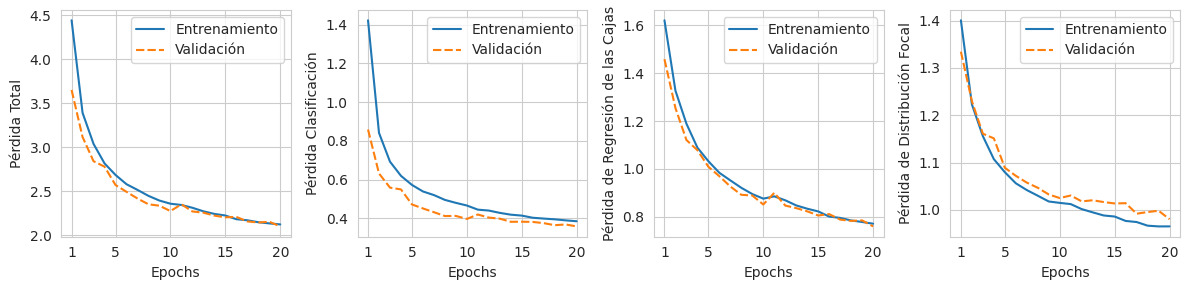

In [ ]:
plot_training_results_yolo("yolov5/results.csv") # "modelos/yolov5/results.csv"

Medimos los FPS:

In [ ]:
_ = measure_fps_yolo(model_yolov5, val_dataset_yolov5)

FPS: 41.33


Medimos la mAP con varios umbrales y promedio:

In [ ]:
_ = measure_map_yolo(model_yolov5, val_dataset_yolov5, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 1627/1627 [00:38<00:00, 42.31it/s]


mAP@0.5: 0.8022
mAP@0.55: 0.7975
mAP@0.6: 0.7913
mAP@0.65: 0.7687
mAP@0.7: 0.7418
mAP@0.75: 0.6976
mAP@0.8: 0.6060
mAP@0.85: 0.4617
mAP@0.9: 0.2433
mAP@0.95: 0.0301
Average mAP: 0.5940


## Conjunto Test

YOLOv5 parece ser el mejor modelo. Lo evaluamos sobre el conjunto test.

In [ ]:
_ = measure_fps_yolo(model_yolov5, test_dataset_yolov5)

FPS: 41.56


In [ ]:
_ = measure_map_yolo(model_yolov5, test_dataset_yolov5, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 3234/3234 [01:17<00:00, 41.97it/s]


mAP@0.5: 0.8073
mAP@0.55: 0.8032
mAP@0.6: 0.7951
mAP@0.65: 0.7774
mAP@0.7: 0.7473
mAP@0.75: 0.7031
mAP@0.8: 0.6194
mAP@0.85: 0.4727
mAP@0.9: 0.2491
mAP@0.95: 0.0282
Average mAP: 0.6003
